In [1]:
# Import libraries:
import scipy.io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Practical Exercise L-6.1 (Face pixel classification)

In this exercise, we will apply pattern classification techniques to 2D face image pixels.

In order to train and evaluate the classifiers, you are provided 75 training and 100 test images. Each image contains 112 x 92 pixels with gray values between 0 (dark) and 255 (white). The file ```train_images.mat``` serves as a container for all training images which are stored as follows: Each row of the matrix contains a complete image with 10304 ($=112*92$) gray values. This is achieved by sequentially storing the individual rows of an image into a row vector. Find another file ```test_images.mat``` with the images required for testing. 

In this exercise we will distinguish 2 classes, **face pixels** and **non-face pixels**,
using two different classifiers: The first is a **minimum-distance classifier** and the second a **Bayes classifier** using two multivariate Gaussian densities with full covariance matrices (one multivariate Gaussian for each class). See the lecture (especially the application example in Chapter 2.6) for further details.

The ground truth information (i.e. which image pixel is a face pixel and which is not) for the training images is provided in the same format as the image data itself and stored in the file ```train_labels.mat```. Face pixels are labeled with 1 and non-face pixels with 0. Note that due to an automatic label generation procedure this ground truth is not at all perfect.

#### Part a.

- Load data.
- Reshape vectors to 2D images.
- Visualise examples.

In [2]:
# Load matlab file containing train and test images plus train labels:
train_images = scipy.io.loadmat('../../data/sheet6/train_images.mat')['train_images']
train_labels = scipy.io.loadmat('../../data/sheet6/train_labels.mat')['train_patterns']
test_images = scipy.io.loadmat('../../data/sheet6/test_images.mat')['test_images']

# Reshape images and labels to 2D data of original size:
train_images_2D = train_images.reshape((-1, 92, 112)).swapaxes(1,2)
train_labels_2D = train_labels.reshape((-1, 92, 112)).swapaxes(1,2)
test_images_2D = test_images.reshape((-1, 92, 112)).swapaxes(1,2)

# Check dimensions:
print('train_images_2D shape:', train_images_2D.shape)
print('train_labels_2D shape:', train_labels_2D.shape)
print('test_images_2D shape:', test_images_2D.shape)

train_images_2D shape: (75, 112, 92)
train_labels_2D shape: (75, 112, 92)
test_images_2D shape: (100, 112, 92)


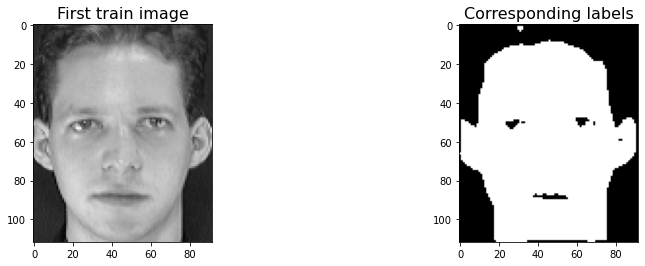

In [3]:
## Plot first training image with corresponding label data:

# Initialize plot, containing two figures:
fig, axes = plt.subplots(1,2,figsize=(14,4))

# Plot first training image as grey scale image:
axes[0].imshow(train_images_2D[0], cmap='gray')

# Plot corresponding labels:
axes[1].imshow(train_labels_2D[0], cmap='gray')

# Add titles:
axes[0].set_title('First train image', fontsize=16)
axes[1].set_title('Corresponding labels', fontsize=16)

plt.show()

#### Part b.

Set up **minimum distance** classifier.

In [10]:
# Get mean grey values from training data separately for face and non-face pixel:
train_mean_face = np.round(np.mean(train_images[train_labels==1]),0)
train_mean_nonface = np.round(np.mean(train_images[train_labels==0]),0)

# Print results:
print('mean grey values from training data for face pixel: ', int(train_mean_face))
print('mean grey values from training data for non-face pixel: ', int(train_mean_nonface))

mean grey values from training data for face pixel:  159
mean grey values from training data for non-face pixel:  69


In [12]:
## Apply minimum distance classifier to test data:

# Get absolute distance of test data grey values to mean grey value for face pixel:
test_dist_face = abs(test_images_2D - train_mean_face)
test_dist_nonface = abs(test_images_2D - train_mean_nonface)

# Get label matrix with 1 for face pixel and 0 for non-face pixel:
test_labels_2D = test_dist_face < test_dist_nonface

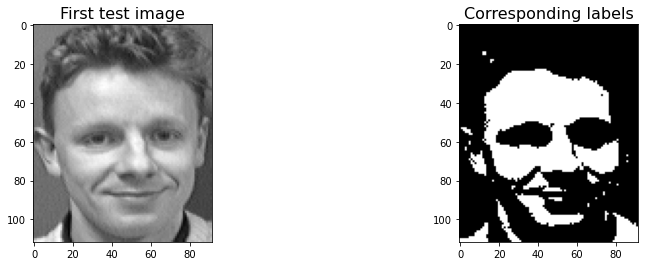

In [14]:
## Plot first test image with corresponding label data:

# Initialize plot, containing two figures:
fig, axes = plt.subplots(1,2,figsize=(14,4))

# Plot first test image as grey scale image:
axes[0].imshow(test_images_2D[0], cmap='gray')

# Plot corresponding labels:
axes[1].imshow(test_labels_2D[0], cmap='gray')

# Add titles:
axes[0].set_title('First test image', fontsize=16)
axes[1].set_title('Corresponding labels', fontsize=16)

plt.show()

#### Part c.

Set up **Bayes classifier** using Gaussian densities for face and non-face pixel grey values. Note that we only have a *single* coulor channel and hence, model densities with univariate Gaussian distributions, separately for each class.

In [21]:
# Compute prior probabilities for face and non-face pixels from relative frequencies in
# training data:
p_face = np.round(np.sum(train_labels==1) / np.size(train_labels), 2)
p_nonface = np.round(np.sum(train_labels==0) / np.size(train_labels), 2)

# Check result:
print('Prior probability for face pixel from training data: ', p_face)
print('Prior probability for non-face pixel from training data: ', p_nonface)

# Alternatively use same prior for both classes:
# p_face = 0.5
# p_nonface = 0.5

Prior probability for face pixel from training data:  0.53
Prior probability for non-face pixel from training data:  0.47


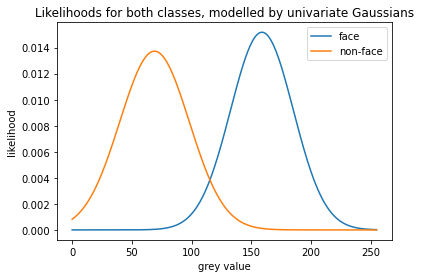

In [38]:
## Compute likelihoods for both classes, face and non-face pixel grey values:

# Have mean grey values from training data separately for face and non-face pixel
# from minimum distance classifier. Additionally, compute variance:
train_var_face = np.round(np.var(train_images[train_labels==1]),0)
train_var_nonface = np.round(np.var(train_images[train_labels==0]),0)

# Create 1D array for full range of grey values from 0 to 255:
grey_scale = np.arange(0, 256, 1)

# Model likelihoods as univariate Gaussian distributions, separately for each class:
p_grey_face = (
    1 / np.sqrt(2 * np.pi * train_var_face) * 
    np.exp(-((grey_scale-train_mean_face)**2) / (2 * train_var_face))
)

p_grey_nonface = (
    1 / np.sqrt(2 * np.pi * train_var_nonface) * 
    np.exp(-((grey_scale-train_mean_nonface)**2) / (2 * train_var_nonface))
)

# Plot resulting distributions (= likelihoods) over the complete grey scale:
plt.plot(p_grey_face, label='face')
plt.plot(p_grey_nonface, label='non-face')
plt.title('Likelihoods for both classes, modelled by univariate Gaussians')
plt.legend()
plt.xlabel('grey value')
plt.ylabel('likelihood')
plt.show()

In [47]:
# Compute posterior probabilities for both, face and non-face pixel grey values, for
# test images using the obtained models for the likelihoods and the prior probabilities.
# Note: We neglect the evidence, since it is identical for both posteriors.
post_face_grey_test = (
    1 / np.sqrt(2 * np.pi * train_var_face) * 
    np.exp(-((test_images_2D-train_mean_face)**2) / (2 * train_var_face))
) * p_face

post_nonface_grey_test = (
    1 / np.sqrt(2 * np.pi * train_var_nonface) * 
    np.exp(-((test_images_2D-train_mean_nonface)**2) / (2 * train_var_nonface))
) * p_nonface

# Get label matrix with 1 for face pixel and 0 for non-face pixel for test data 
# from resulting maximum likelihood:
test_labels_2D_Bayes = post_face_grey_test > post_nonface_grey_test

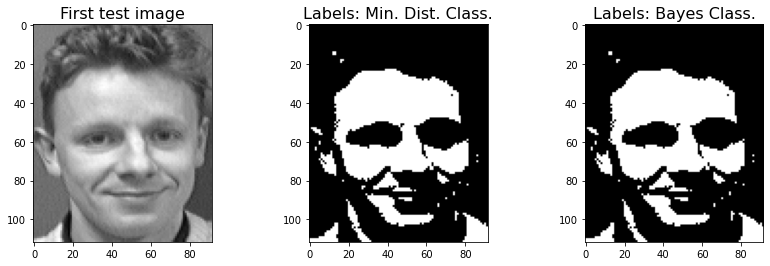

In [50]:
## Plot first test image with corresponding label data, obtained from both classifiers:

# Initialize plot, containing three figures:
fig, axes = plt.subplots(1,3,figsize=(14,4))

# Plot first test image as grey scale image:
axes[0].imshow(test_images_2D[0], cmap='gray')

# Plot corresponding labels, obtained from minimum distance classifier:
axes[1].imshow(test_labels_2D[0], cmap='gray')

# Plot corresponding labels, obtained from Bayes classifier:
axes[2].imshow(test_labels_2D_Bayes[0], cmap='gray')

# Add titles:
axes[0].set_title('First test image', fontsize=16)
axes[1].set_title('Labels: Min. Dist. Class.', fontsize=16)
axes[2].set_title('Labels: Bayes Class.', fontsize=16)

plt.show()

### Discussion

We compared the minimum distance classifier to a Bayes classifier for the task of face pixel classification. Both results appear to be identical for all test images.